In [2]:
%load_ext autoreload
%autoreload 2
%pip install colour ruptures
import pandas as pd
import numpy as np
import bz2
import csv
import io
import json
import re
import time
import random
import requests
import datetime
from tqdm import tqdm
import json
from matplotlib import ticker
from colour import Color
import ruptures as rpt
from pathlib import Path
from pprint import pprint
from typing import List, Dict
from dateutil.relativedelta import relativedelta
import lsde2021.csv as csvutils
import lsde2021.utils as utils
import lsde2021.download as dl
from pyspark.sql import SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as F

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,3)

Note: you may need to restart the kernel to use updated packages.


In [3]:
MAX_MEMORY = "30G"

spark = SparkSession \
    .builder \
    .appName("parse-wikipedia-sql-dumps") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .config('spark.driver.maxResultSize', MAX_MEMORY) \
    .config('spark.ui.showConsoleProgress', 'false') \
    .getOrCreate()
sc = spark.sparkContext

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/03 12:31:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
21/11/03 12:31:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/11/03 12:31:17 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
21/11/03 12:31:17 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [22]:
stringency_schema = T.StructType([
    T.StructField("CountryName", T.StringType(), True),
    T.StructField("CountryCode",T.StringType(), True),
    T.StructField("RegionName", T.StringType(), True),
    T.StructField("RegionCode", T.StringType(), True),
    T.StructField("Jurisdiction", T.StringType(), True),
    T.StructField("Date", T.StringType(), True),
    T.StructField("C1_School closing", T.FloatType(), True),
    T.StructField("C1_Flag", T.IntegerType(), True),
    T.StructField('C1_Notes', T.StringType(), True),
    T.StructField('C2_Workplace closing', T.FloatType(), True),
    T.StructField('C2_Flag', T.IntegerType(), True),
    T.StructField('C2_Notes', T.StringType(), True),
    T.StructField('C3_Cancel public events', T.FloatType(), True),
    T.StructField('C3_Flag', T.IntegerType(), True),
    T.StructField('C3_Notes', T.StringType(), True),
    T.StructField('C4_Restrictions on gatherings', T.FloatType(), True),
    T.StructField('C4_Flag', T.IntegerType(), True),
    T.StructField('C4_Notes', T.StringType(), True),
    T.StructField('C5_Close public transport', T.FloatType(), True),
    T.StructField('C5_Flag', T.IntegerType(), True),
    T.StructField('C5_Notes', T.StringType(), True),
    T.StructField('C6_Stay at home requirements', T.FloatType(), True),
    T.StructField('C6_Flag', T.IntegerType(), True),
    T.StructField('C6_Notes', T.StringType(), True),
    T.StructField('C7_Restrictions on internal movement', T.FloatType(), True),
    T.StructField('C7_Flag', T.IntegerType(), True),
    T.StructField('C7_Notes', T.StringType(), True),
    T.StructField('C8_International travel controls', T.FloatType(), True),
    T.StructField('C8_Notes', T.StringType(), True),
    T.StructField('E1_Income support', T.FloatType(), True),
    T.StructField('E1_Flag', T.IntegerType(), True),
    T.StructField('E1_Notes', T.StringType(), True),
    T.StructField('E2_Debt/contract relief', T.FloatType(), True),
    T.StructField('E2_Notes', T.StringType(), True),
    T.StructField('E3_Fiscal measures', T.FloatType(), True),
    T.StructField('E3_Notes', T.StringType(), True),
    T.StructField('E4_International support', T.FloatType(), True),
    T.StructField('E4_Notes', T.StringType(), True),
    T.StructField('H1_Public information campaigns', T.FloatType(), True),
    T.StructField('H1_Flag', T.IntegerType(), True),
    T.StructField('H1_Notes', T.StringType(), True),
    T.StructField('H2_Testing policy', T.FloatType(), True),
    T.StructField('H2_Notes', T.StringType(), True),
    T.StructField('H3_Contact tracing', T.FloatType(), True),
    T.StructField('H3_Notes', T.StringType(), True),
    T.StructField('H4_Emergency investment in healthcare', T.FloatType(), True),
    T.StructField('H4_Notes', T.StringType(), True),
    T.StructField('H5_Investment in vaccines', T.FloatType(), True),
    T.StructField('H5_Notes', T.StringType(), True),
    T.StructField('H6_Facial Coverings', T.FloatType(), True),
    T.StructField('H6_Flag', T.IntegerType(), True),
    T.StructField('H6_Notes', T.StringType(), True),
    T.StructField('H7_Vaccination policy', T.FloatType(), True),
    T.StructField('H7_Flag', T.IntegerType(), True),
    T.StructField('H7_Notes', T.StringType(), True),
    T.StructField('H8_Protection of elderly people', T.FloatType(), True),
    T.StructField('H8_Flag', T.IntegerType(), True),
    T.StructField('H8_Notes', T.StringType(), True),
    T.StructField('M1_Wildcard', T.FloatType(), True),
    T.StructField('M1_Notes', T.StringType(), True),
    T.StructField('ConfirmedCases', T.FloatType(), True),
    T.StructField('ConfirmedDeaths', T.FloatType(), True),
    T.StructField('StringencyIndex', T.FloatType(), True),
    T.StructField('StringencyIndexForDisplay', T.FloatType(), True),
    T.StructField('StringencyLegacyIndex', T.FloatType(), True),
    T.StructField('StringencyLegacyIndexForDisplay', T.FloatType(), True),
    T.StructField('GovernmentResponseIndex', T.FloatType(), True),
    T.StructField('GovernmentResponseIndexForDisplay', T.FloatType(), True),
    T.StructField('ContainmentHealthIndex', T.FloatType(), True),
    T.StructField('ContainmentHealthIndexForDisplay', T.FloatType(), True),
    T.StructField('EconomicSupportIndex', T.FloatType(), True),
    T.StructField('EconomicSupportIndexForDisplay', T.FloatType(), True),
])

stringency2020 = spark.read.format("csv").schema(stringency_schema).options(escape="\"", multiline="true", header="true", delimiter=',') \
    .load("../nvme/oxcgrt-covid-policy-tracker/OxCGRT_withnotes_2020.csv")
stringency2021 = spark.read.format("csv").schema(stringency_schema).options(escape="\"", multiline="true", header="true", delimiter=',') \
    .load("../nvme/oxcgrt-covid-policy-tracker/OxCGRT_withnotes_2021.csv")

stringency = stringency2020.union(stringency2021)
stringency = stringency \
    .withColumnRenamed("C1_School closing","C1_School_closing") \
    .withColumnRenamed("C2_Workplace closing","C2_Workplace_closing") \
    .withColumnRenamed("C3_Cancel public events","C3_Cancel_public_events") \
    .withColumnRenamed("C4_Restrictions on gatherings","C4_Restrictions_on_gatherings") \
    .withColumnRenamed("C5_Close public transport","C5_Close_public_transport") \
    .withColumnRenamed("C6_Stay at home requirements","C6_Stay_at_home_requirements") \
    .withColumnRenamed("C7_Restrictions on internal movement","C7_Restrictions_on_internal_movement") \
    .withColumnRenamed("C8_International travel controls","C8_International_travel_controls") \
    .withColumnRenamed("E1_Income support","E1_Income_support") \
    .withColumnRenamed("E2_Debt/contract relief","E2_Debt/contract_relief") \
    .withColumnRenamed("E3_Fiscal measures","E3_Fiscal_measures") \
    .withColumnRenamed("E4_International support","E4_International_support") \
    .withColumnRenamed("H1_Public information campaigns","H1_Publicinformation_campaigns") \
    .withColumnRenamed("H2_Testing policy","H2_Testing_policy") \
    .withColumnRenamed("H3_Contact tracing","H3_Contact_tracing") \
    .withColumnRenamed("H4_Emergency investment in healthcare","H4_Emergency_investment_in_healthcare") \
    .withColumnRenamed("H5_Investment in vaccines","H5_Investment_in_vaccines") \
    .withColumnRenamed("H6_Facial Coverings","H6_Facial_Coverings") \
    .withColumnRenamed("H7_Vaccination policy","H7_Vaccination_policy") \
    .withColumnRenamed("H8_Protection of elderly people","H8_Protection_of_elderly_people")

stringency = stringency.withColumn("Date", F.to_timestamp("Date", "yyyyMMdd"))

notes_cols = [
    "C1_Notes",
    "C2_Notes",
    "C3_Notes",
    "C4_Notes",
    "C5_Notes",
    "C6_Notes",
    "C7_Notes",
    "C8_Notes",
    "E1_Notes",
    "E2_Notes",
    "E3_Notes",
    "E4_Notes",
    "H1_Notes",
    "H2_Notes",
    "H3_Notes",
    "H4_Notes",
    "H5_Notes",
    "H6_Notes",
    "H7_Notes",
    "H8_Notes",
    "M1_Notes"
]

# combine notes
stringency = stringency \
    .withColumn("Notes", F.array(*notes_cols)) \
    .withColumn("Notes", F.expr("FILTER(Notes, x -> x is not null)"))
    # .withColumn('Notes', F.explode('Notes'))
    
stringency.select("Date", "CountryName", "CountryCode", "StringencyIndex", "Notes").filter((F.col("CountryName") == "Germany") & (F.size(F.col("Notes")) > 0)).show()

stringency.write.format("parquet").mode("overwrite").save(f"../nvme/oxcgrt-covid-policy-tracker/OxCGRT_withnotes.parquet")

+-------------------+-----------+-----------+---------------+--------------------+
|               Date|CountryName|CountryCode|StringencyIndex|               Notes|
+-------------------+-----------+-----------+---------------+--------------------+
|2020-01-01 00:00:00|    Germany|        DEU|            0.0|[The existing cod...|
|2020-01-22 00:00:00|    Germany|        DEU|            0.0|[Robert-Koch-Inst...|
|2020-01-24 00:00:00|    Germany|        DEU|           5.56|[German health mi...|
|2020-01-25 00:00:00|    Germany|        DEU|           5.56|[German governmen...|
|2020-01-27 00:00:00|    Germany|        DEU|           5.56|[This date is cho...|
|2020-01-28 00:00:00|    Germany|        DEU|           5.56|[Federal Governme...|
|2020-02-03 00:00:00|    Germany|        DEU|           5.56|[Health minister ...|
|2020-02-06 00:00:00|    Germany|        DEU|           5.56|[CEPI (Coalition ...|
|2020-02-12 00:00:00|    Germany|        DEU|          11.11|[German health mi...|
|202

In [39]:
# print(vaccines.columns.tolist())

vaccines_schema = T.StructType([
    T.StructField("CountryName", T.StringType(), True),
    T.StructField("CountryCode",T.StringType(), True),
    T.StructField("RegionName", T.StringType(), True),
    T.StructField("RegionCode", T.StringType(), True),
    T.StructField("Jurisdiction", T.StringType(), True),
    T.StructField("Date", T.StringType(), True),
    T.StructField("C1_School closing", T.FloatType(), True),
    T.StructField("C1_Flag", T.IntegerType(), True),
    T.StructField('C1_Notes', T.StringType(), True),
    T.StructField('C2_Workplace closing', T.FloatType(), True),
    T.StructField('C2_Flag', T.IntegerType(), True),
    T.StructField('C2_Notes', T.StringType(), True),
    T.StructField('C3_Cancel public events', T.FloatType(), True),
    T.StructField('C3_Flag', T.IntegerType(), True),
    T.StructField('C3_Notes', T.StringType(), True),
    T.StructField('C4_Restrictions on gatherings', T.FloatType(), True),
    T.StructField('C4_Flag', T.IntegerType(), True),
    T.StructField('C4_Notes', T.StringType(), True),
    T.StructField('C5_Close public transport', T.FloatType(), True),
    T.StructField('C5_Flag', T.IntegerType(), True),
    T.StructField('C5_Notes', T.StringType(), True),
    T.StructField('C6_Stay at home requirements', T.FloatType(), True),
    T.StructField('C6_Flag', T.IntegerType(), True),
    T.StructField('C6_Notes', T.StringType(), True),
    T.StructField('C7_Restrictions on internal movement', T.FloatType(), True),
    T.StructField('C7_Flag', T.IntegerType(), True),
    T.StructField('C7_Notes', T.StringType(), True),
    T.StructField('C8_International travel controls', T.FloatType(), True),
    T.StructField('C8_Notes', T.StringType(), True),
    T.StructField('E1_Income support', T.FloatType(), True),
    T.StructField('E1_Flag', T.IntegerType(), True),
    T.StructField('E1_Notes', T.StringType(), True),
    T.StructField('E2_Debt/contract relief', T.FloatType(), True),
    T.StructField('E2_Notes', T.StringType(), True),
    T.StructField('E3_Fiscal measures', T.FloatType(), True),
    T.StructField('E3_Notes', T.StringType(), True),
    T.StructField('E4_International support', T.FloatType(), True),
    T.StructField('E4_Notes', T.StringType(), True),
    T.StructField('H1_Public information campaigns', T.FloatType(), True),
    T.StructField('H1_Flag', T.IntegerType(), True),
    T.StructField('H1_Notes', T.StringType(), True),
    T.StructField('H2_Testing policy', T.FloatType(), True),
    T.StructField('H2_Notes', T.StringType(), True),
    T.StructField('H3_Contact tracing', T.FloatType(), True),
    T.StructField('H3_Notes', T.StringType(), True),
    T.StructField('H4_Emergency investment in healthcare', T.FloatType(), True),
    T.StructField('H4_Notes', T.StringType(), True),
    T.StructField('H5_Investment in vaccines', T.FloatType(), True),
    T.StructField('H5_Notes', T.StringType(), True),
    T.StructField('H6_Facial Coverings', T.FloatType(), True),
    T.StructField('H6_Flag', T.IntegerType(), True),
    T.StructField('H6_Notes', T.StringType(), True),
    T.StructField('H7_Vaccination policy', T.FloatType(), True),
    T.StructField('H7_Flag', T.IntegerType(), True),
    T.StructField('H7_Notes', T.StringType(), True),
    T.StructField('H8_Protection of elderly people', T.FloatType(), True),
    T.StructField('H8_Flag', T.IntegerType(), True),
    T.StructField('H8_Notes', T.StringType(), True),
    T.StructField('M1_Wildcard', T.FloatType(), True),
    T.StructField('M1_Notes', T.StringType(), True),
    T.StructField('ConfirmedCases', T.FloatType(), True),
    T.StructField('ConfirmedDeaths', T.FloatType(), True),
    T.StructField('StringencyIndex', T.FloatType(), True),
    T.StructField('StringencyIndexForDisplay', T.FloatType(), True),
    T.StructField('StringencyLegacyIndex', T.FloatType(), True),
    T.StructField('StringencyLegacyIndexForDisplay', T.FloatType(), True),
    T.StructField('GovernmentResponseIndex', T.FloatType(), True),
    T.StructField('GovernmentResponseIndexForDisplay', T.FloatType(), True),
    T.StructField('ContainmentHealthIndex', T.FloatType(), True),
    T.StructField('ContainmentHealthIndexForDisplay', T.FloatType(), True),
    T.StructField('EconomicSupportIndex', T.FloatType(), True),
    T.StructField('EconomicSupportIndexForDisplay', T.FloatType(), True),
])

# vaccines = pd.read_csv("../nvme/oxcgrt-covid-policy-tracker/OxCGRT_vaccines_full.csv")
vaccines = spark.read.format("csv").options(header=True).load("../nvme/oxcgrt-covid-policy-tracker/OxCGRT_vaccines_full.csv")
vaccines = vaccines.withColumn("Date", F.to_timestamp("Date", "yyyyMMdd"))
pprint(vaccines.toPandas().columns.tolist())\

vaccines = vaccines.select(*[
    'CountryName',
    'CountryCode',
    'Date',
    F.col('V3_Vaccine Financial Support (summary)').alias("V3_Vaccine_Financial_Support_summary"),
    F.col('V3_0-4 yrs infants').alias("V3_0-4_yrs_infants"),
    F.col('V3_5-15 yrs young people').alias("V3_5-15_yrs_young_people"),
    F.col('V3_Airport/Border/Airline Staff').alias("V3_Airport_Border_Airline_Staff"),
    F.col('V3_At Risk 16-19 yrs').alias("V3_At_Risk_16-19_yrs"),
    F.col('V3_At Risk 20-24 yrs').alias("V3_At_Risk_20-24_yrs"),
    F.col('V3_At Risk 25-29 yrs').alias("V3_At_Risk_25-29_yrs"),
    F.col('V3_At Risk 30-34 yrs').alias("V3_At_Risk_30-34_yrs"),
    F.col('V3_At Risk 35-39 yrs').alias("V3_At_Risk_35-39_yrs"),
    F.col('V3_At Risk 40-44 yrs').alias("V3_At_Risk_40-44_yrs"),
    F.col('V3_At Risk 45-49 yrs').alias("V3_At_Risk_45-49_yrs"),
    F.col('V3_At Risk 50-54 yrs').alias("V3_At_Risk_50-54_yrs"),
    F.col('V3_At Risk 55-59 yrs').alias("V3_At_Risk_55-59_yrs"),
    F.col('V3_At Risk 60-64 yrs').alias("V3_At_Risk_60-64_yrs"),
    F.col('V3_At Risk 65-69 yrs').alias("V3_At_Risk_65-69_yrs"),
    F.col('V3_At Risk 70-74 yrs').alias("V3_At_Risk_70-74_yrs"),
    F.col('V3_At Risk 75-79 yrs').alias("V3_At_Risk_75-79_yrs"),
    F.col('V3_At Risk 80+ yrs').alias("V3_At_Risk_80+_yrs"),
    F.col('V3_Clinically vulnerable/chronic illness/significant underlying health condition (excluding elderly and disabled)').alias("V3_Clinically_vulnerable_chronic_illness_significant_underlying_health_condition_excluding_elderly_and_disabled"),
    F.col('V3_Crowded/communal living conditions (dormitories for migrant workers, temporary accommodation)').alias("V3_Crowded_communal_living_conditions_dormitories_for_migrant_workers_temporary_accommodation"),
    F.col('V3_Disabled People').alias('V3_Disabled_People'),
    F.col('V3_Educators').alias('V3_Educators'),
    F.col('V3_Ethnic minorities').alias('V3_Ethnic_minorities'),
    F.col('V3_Factory workers').alias('V3_Factory_workers'),
    F.col('V3_Frontline retail workers').alias('V3_Frontline_retail_workers'),
    F.col('V3_Frontline/essential workers (when subcategories not specified)').alias('V3_Frontline_essential_workers_when_subcategories_not_specified'),
    F.col('V3_General 16-19 yrs').alias('V3_General_16-19_yrs'),
    F.col('V3_General 20-24 yrs').alias('V3_General_20-24_yrs'),
    F.col('V3_General 25-29 yrs').alias('V3_General_25-29_yrs'),
    F.col('V3_General 30-34 yrs').alias('V3_General_30-34_yrs'),
    F.col('V3_General 35-39 yrs').alias('V3_General_35-39_yrs'),
    F.col('V3_General 40-44 yrs').alias('V3_General_40-44_yrs'),
    F.col('V3_General 45-49 yrs').alias('V3_General_45-49_yrs'),
    F.col('V3_General 50-54 yrs').alias('V3_General_50-54_yrs'),
    F.col('V3_General 55-59 yrs').alias('V3_General_55-59_yrs'),
    F.col('V3_General 60-64 yrs').alias('V3_General_60-64_yrs'),
    F.col('V3_General 65-69 yrs').alias('V3_General_65-69_yrs'),
    F.col('V3_General 70-74 yrs').alias('V3_General_70-74_yrs'),
    F.col('V3_General 75-79 yrs').alias('V3_General_75-79_yrs'),
    F.col('V3_General 80+ yrs').alias('V3_General_80+_yrs'),
    F.col('V3_Healthcare workers/carers (excluding care home staff)').alias('V3_Healthcare_workers_carers_excluding_care_home_staff'),
    F.col('V3_Military ').alias('V3_Military'),
    F.col("V3_Other 'high contact' professions/groups (taxi drivers, security guards)").alias("V3_Other_high_contact_professions_groups_taxi_drivers_security_guards"),
    F.col('V3_People living with a vulnerable/shielding person or other priority group').alias('V3_People_living_with_a_vulnerable_shielding_person_or_other_priority_group'),
    F.col('V3_Police/ first responders').alias('V3_Police_first_responders'),
    F.col('V3_Pregnant people').alias('V3_Pregnant_people'),
    F.col('V3_Primary and secondary school students').alias('V3_Primary_and_secondary_school_students'),
    F.col('V3_Religious/Spiritual Leaders').alias('V3_Religious_Spiritual_Leaders'),
    F.col('V3_Residents in an elderly care home ').alias('V3_Residents_in_an_elderly_care_home'),
    F.col('V3_Staff working in an elderly care home').alias('V3_Staff_working_in_an_elderly_care_home'),
    F.col('V3_Tertiary education students').alias('V3_Tertiary_education_students'),
    F.col('V3_Notes').alias('V3_Notes'),
])
vaccines = vaccines.fillna(0)
vaccines = vaccines.withColumn('V3_General_All_age_groups', (
    F.col('V3_General_16-19_yrs')
    + F.col('V3_General_20-24_yrs')
    + F.col('V3_General_25-29_yrs')
    + F.col('V3_General_30-34_yrs')
    + F.col('V3_General_35-39_yrs')
    + F.col('V3_General_40-44_yrs')
    + F.col('V3_General_45-49_yrs')
    + F.col('V3_General_50-54_yrs')
    + F.col('V3_General_55-59_yrs')
    + F.col('V3_General_60-64_yrs')
    + F.col('V3_General_65-69_yrs')
    + F.col('V3_General_70-74_yrs')
    + F.col('V3_General_75-79_yrs')
    + F.col('V3_General_80+_yrs')
))
vaccines.write.format("parquet").mode("overwrite").save("../nvme/oxcgrt-covid-policy-tracker/OxCGRT_vaccines_full.parquet")

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


['CountryName',
 'CountryCode',
 'Date',
 'V1_Vaccine Prioritisation (summary)',
 'V1_0-4 yrs infants',
 'V1_5-15 yrs young people',
 'V1_Airport/Border/Airline Staff',
 'V1_At Risk 16-19 yrs',
 'V1_At Risk 20-24 yrs',
 'V1_At Risk 25-29 yrs',
 'V1_At Risk 30-34 yrs',
 'V1_At Risk 35-39 yrs',
 'V1_At Risk 40-44 yrs',
 'V1_At Risk 45-49 yrs',
 'V1_At Risk 50-54 yrs',
 'V1_At Risk 55-59 yrs',
 'V1_At Risk 60-64 yrs',
 'V1_At Risk 65-69 yrs',
 'V1_At Risk 70-74 yrs',
 'V1_At Risk 75-79 yrs',
 'V1_At Risk 80+ yrs',
 'V1_Clinically vulnerable/chronic illness/significant underlying health '
 'condition (excluding elderly and disabled)',
 'V1_Crowded/communal living conditions (dormitories for migrant workers, '
 'temporary accommodation)',
 'V1_Disabled People',
 'V1_Educators',
 'V1_Ethnic minorities',
 'V1_Factory workers',
 'V1_Frontline retail workers',
 'V1_Frontline/essential workers (when subcategories not specified)',
 'V1_General 16-19 yrs',
 'V1_General 20-24 yrs',
 'V1_General 25-

In [4]:
stringency = spark.read.format("parquet").load(f"../nvme/oxcgrt-covid-policy-tracker/OxCGRT_withnotes.parquet")
vaccines = spark.read.format("parquet").load(f"../nvme/oxcgrt-covid-policy-tracker/OxCGRT_vaccines_full.parquet")
languages = pd.read_csv("./data/languages.csv", index_col="code")

In [15]:
# ("C1_School closing","C1_School_closing") \
pprint(cp.COUNTRIES)
# stringency.
# where(size(col("tokens")) <= 3).show()
# vaccines.select("CountryName", "Date", "V3_General_16-19_yrs").show()

NameError: name 'cp' is not defined

In [23]:
# print(stringency.dtypes)
# print(stringency["stringencyindex"].unique().tolist())
# vaccines.head()
# pprint(vaccines.columns.tolist())

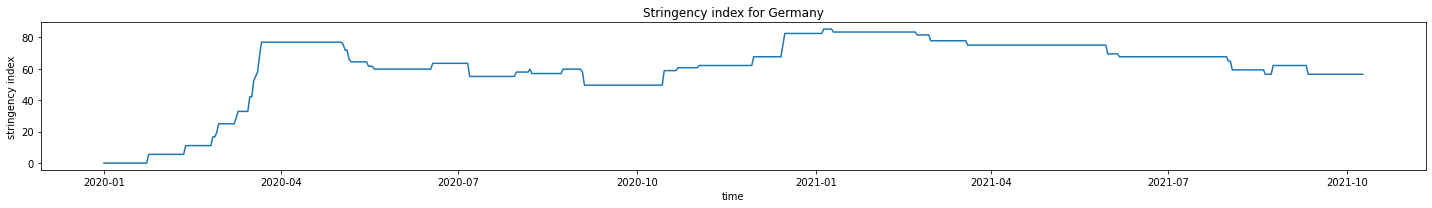

In [24]:
# plot the data for germany to get a feel
germany = stringency.filter(F.col("CountryName") == "Germany").select("Date", "StringencyIndex").toPandas().set_index("Date")
plt.plot(germany)
plt.title("Stringency index for Germany")
plt.xlabel("time")
plt.ylabel("stringency index")
plt.tight_layout()
plt.savefig("./figs/stringency_germany.pdf")
plt.show()

+-----------+-------------------+--------------------+
|CountryName|               Date|V3_General_16-19_yrs|
+-----------+-------------------+--------------------+
|  Australia|2020-01-01 00:00:00|                null|
|  Australia|2020-01-02 00:00:00|                null|
|  Australia|2020-01-03 00:00:00|                null|
|  Australia|2020-01-04 00:00:00|                null|
|  Australia|2020-01-05 00:00:00|                null|
|  Australia|2020-01-06 00:00:00|                null|
|  Australia|2020-01-07 00:00:00|                null|
|  Australia|2020-01-08 00:00:00|                null|
|  Australia|2020-01-09 00:00:00|                null|
|  Australia|2020-01-10 00:00:00|                null|
|  Australia|2020-01-11 00:00:00|                null|
|  Australia|2020-01-12 00:00:00|                null|
|  Australia|2020-01-13 00:00:00|                null|
|  Australia|2020-01-14 00:00:00|                null|
|  Australia|2020-01-15 00:00:00|                null|
|  Austral

TypeError: unhashable type: 'numpy.ndarray'

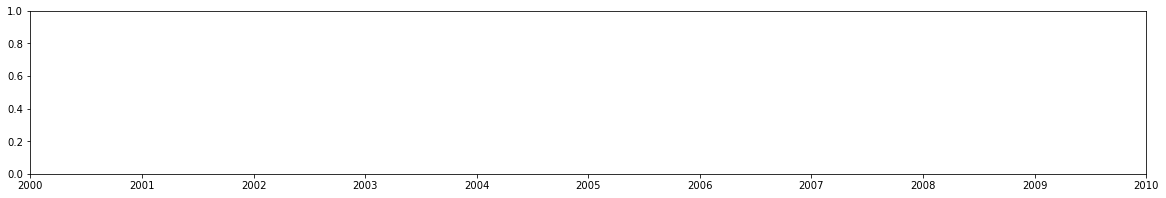

In [38]:
# plot the vaccination for germany to get a feel
# df = vaccines
country = "Germany"
country = "United Kingdom"
age_groups = [
    'V3_General_16-19_yrs',
    'V3_General_20-24_yrs',
    'V3_General_25-29_yrs',
    'V3_General_30-34_yrs',
    'V3_General_35-39_yrs',
    'V3_General_40-44_yrs',
    'V3_General_45-49_yrs',
    'V3_General_50-54_yrs',
    'V3_General_55-59_yrs',
    'V3_General_60-64_yrs',
    'V3_General_65-69_yrs',
    'V3_General_70-74_yrs',
    'V3_General_75-79_yrs',
    'V3_General_80+_yrs',
]
# germany = df.loc[df["countryname"] == country,:].copy()
vaccines.select("CountryName", "Date", "V3_General_16-19_yrs").show()
germany = vaccines \
    .filter(F.col("CountryName") == country) \
    .groupBy("CountryName", "Date") \
    .agg(F.sum("V3_General_All_age_groups").alias("Total")) \
    .toPandas().set_index("Date")

print(germany.head())
# germany["total"] = 0
# for age in age_groups:
#     germany["total"] += germany[age].fillna(0.0)
# germany = germany[["Date", "Total"]]
# .set_index("date")
plt.plot(germany)
plt.title("Vaccination rate for all age groups for %s" % country)
plt.xlabel("time")
plt.ylabel("vaccination rate")
plt.show()

In [ ]:
if False:
        df = df.rename(columns={
            "CountryName": "country_name",
            'CountryCode': "country_code",
            'RegionName': "region_name",
            "RegionCode": "region_code",
            "Jurisdiction": "jurisdiction",
            "Date": "date",
            "C1_School closing": "c1_school_closing",
            "C1_Flag": "c1_flag",
            "C1_Notes": "c1_notes",
            "C2_Workplace closing": "c2_workplace_closing",
            "StringencyIndex": "stringency_index",
            "StringencyIndexForDisplay": "stringency_index_for_display",
            "StringencyLegacyIndex": "stringency_legacy_index",
            "StringencyLegacyIndexForDisplay": "stringency_legacy_index_for_display",
            "GovernmentResponseIndex": "government_response_index",
            "GovernmentResponseIndexForDisplay": "government_response_index_for_display",
            "ContainmentHealthIndex": "containment_health_index",
            "ContainmentHealthIndexForDisplay": "containment_health_index_for_display",
            "EconomicSupportIndex": "economic_support_index",
            "EconomicSupportIndexForDisplay": "economic_support_index_for_display",
        })